<hr style="border:2px solid gray"> </hr>

# Machine Learning
<hr style="border:2px solid gray"> </hr>

# Step 0. Import packages and Global Settings

In [1]:
import os, glob, numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


data_name = 'image_data.npy'
category_file_name = 'Categories.txt'
model_dir = './model'

# Step 1. Data Loading

In [2]:
X_train, X_test, y_train, y_test = np.load(data_name, allow_pickle=True)

X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(16137, 128, 128, 3) (16137, 100)
(5380, 128, 128, 3) (5380, 100)


In [3]:
import codecs
category_file = codecs.open(category_file_name, 'r', 'utf-8')
categories = list(map(str.strip, category_file.readlines()))
classes = len(categories)

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5482381169543305834,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1492284738299236003
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4977159040
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15664341355618531537
 physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11079798954351015857
 physical_device_desc: "device: XLA_GPU device"]

# Step 2. Define Model

In [5]:
with tf.device('/device:GPU:0'):
    model = Sequential([
        Conv2D(32, (7,7), padding="same", input_shape=X_train.shape[1:], activation='relu', strides=(2, 2)),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Dropout(0.25),

        Conv2D(64, (4,4), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Dropout(0.25),

        Conv2D(128, (2,2), padding="same", activation='relu'),
        Conv2D(128, (2,2), padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(1000, activation='relu',kernel_regularizer=l2(0.05)),
        Dense(300, activation='relu',kernel_regularizer=l2(0.05)),
        Dense(classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       3

# Training

In [7]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200, validation_data=(X_test, y_test), callbacks=[])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

5 - accuracy: 0.3544 - val_loss: 2.9663 - val_accuracy: 0.3020
Epoch 63/200
64/64 [==============================] - 6s 87ms/step - loss: 2.6526 - accuracy: 0.3537 - val_loss: 2.8553 - val_accuracy: 0.3320
Epoch 64/200
64/64 [==============================] - 6s 87ms/step - loss: 2.6367 - accuracy: 0.3602 - val_loss: 3.0389 - val_accuracy: 0.3145
Epoch 65/200
64/64 [==============================] - 6s 88ms/step - loss: 2.6538 - accuracy: 0.3528 - val_loss: 3.0676 - val_accuracy: 0.2901
Epoch 66/200
64/64 [==============================] - 6s 86ms/step - loss: 2.6292 - accuracy: 0.3648 - val_loss: 2.8482 - val_accuracy: 0.3344
Epoch 67/200
64/64 [==============================] - 5s 85ms/step - loss: 2.6240 - accuracy: 0.3631 - val_loss: 2.8757 - val_accuracy: 0.3296
Epoch 68/200
64/64 [==============================] - 5s 84ms/step - loss: 2.5902 - accuracy: 0.3641 - val_loss: 2.8082 - val_accuracy: 0.3381
Epoch 69/200
64/64 [==============================] - 5s 85ms/step - loss: 2.60

# Test

In [8]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

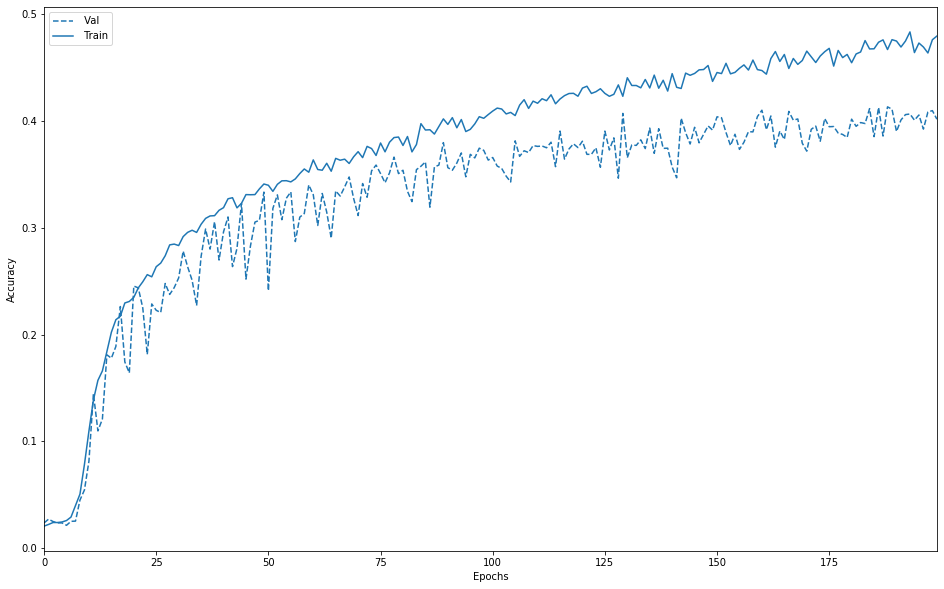

In [10]:
plot_history([('', history)], 'accuracy')